In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain
import pandas as pd
import numpy as np



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 23 09:02:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")


In [ ]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

reviews[reviews['category'].str.contains("HEALTHY LIVING")]

reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

reviews['healthy'].describe()

count    200853.000000
mean          0.033328
std           0.179492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy, dtype: float64

In [ ]:
# We have replaced the sample count with a smaller number in order to expedite
# the completion of the lab. For your final project, you will want to use the
# full balanced document set which is determined by this commented line:
#sample_amount =  len(reviews[reviews["healthy"] == 1]) # the total number of healthy living articles

sample_amount = len(reviews[reviews["healthy"] == 1])

healthy = reviews[reviews['healthy'] == 1].sample(n=sample_amount)
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)

review_sample = pd.concat([healthy,not_healthy])

review_sample.describe()

,healthy
count,13388.000000
mean,0.500000
std,0.500019
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']


train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["healthy"],
    val_df=None,
    max_features=20000,
    maxlen=128,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="bert",
    verbose=1
)

['not_healthy', 'healthy']
        not_healthy  healthy
181193          1.0      0.0
18037           0.0      1.0
195310          1.0      0.0
86065           1.0      0.0
7965            1.0      0.0
['not_healthy', 'healthy']
       not_healthy  healthy
23784          0.0      1.0
7635           1.0      0.0
86407          0.0      1.0
95645          1.0      0.0
21663          1.0      0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = ktrain.text.text_classifier('bert', train_data=train, preproc=preprocess)

learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=8)

Is Multi-Label? False
maxlen is 128


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [ ]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/6
1507/1507 [==============================] - 404s 249ms/step - loss: 0.6139 - accuracy: 0.6407
Epoch 2/6
1507/1507 [==============================] - 379s 252ms/step - loss: 0.3571 - accuracy: 0.8524
Epoch 3/6
1507/1507 [==============================] - 384s 255ms/step - loss: 0.5619 - accuracy: 0.6634
Epoch 4/6
1507/1507 [==============================] - 355s 236ms/step - loss: 1.0487 - accuracy: 0.5038


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


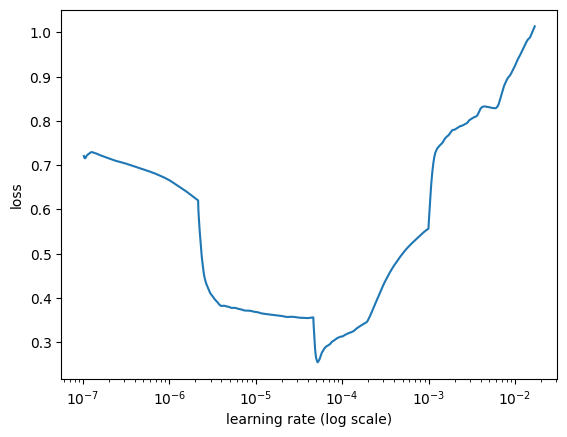

In [ ]:
learner.lr_plot()

In [ ]:
history=learner.autofit(
    5e-5,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/10
1507/1507 [==============================] - 425s 266ms/step - loss: 0.3689 - accuracy: 0.8387 - val_loss: 0.2920 - val_accuracy: 0.8835
Epoch 2/10
1507/1507 [==============================] - 403s 267ms/step - loss: 0.2218 - accuracy: 0.9134 - val_loss: 0.3021 - val_accuracy: 0.8813
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

42/42 [==============================] - 17s 269ms/step
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       648
           1       0.85      0.94      0.89       691

    accuracy                           0.88      1339
   macro avg       0.89      0.88      0.88      1339
weighted avg       0.89      0.88      0.88      1339



In [ ]:
#predictor.save("drive/MyDrive/MSDSTextClassification_Lab2.healthy_living")